In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

In [ ]:
class ToyModel(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.in_features = config.in_features
    self.hidden_dim = config.hidden_dim

    self.weight = nn.Parameter(torch.randn(self.hidden_dim, self.in_features), requires_grad=True)
    self.bias = nn.Parameter(torch.randn(self.in_features), requires_grad=True)

  def forward(self, x):
    h = torch.einsum("mn,bn->bm", self.weight, x) # [batch_size, hidden_dim]
    out = torch.einsum("bm,mn->bn", h, self.weight) # [batch_size, in_features]
    out += self.bias
    return out

In [ ]:
class ToyModelActivation(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.in_features = config.in_features
    self.hidden_dim = config.hidden_dim

    self.weight = nn.Parameter(torch.randn(self.hidden_dim, self.in_features), requires_grad=True)
    self.bias = nn.Parameter(torch.randn(self.in_features), requires_grad=True)
    self.act = nn.ReLU()

  def forward(self, x):
    h = torch.einsum("mn,bn->bm", self.weight, x) # [batch_size, hidden_dim]
    out = torch.einsum("bm,mn->bn", h, self.weight) # [batch_size, in_features]
    out += self.bias
    return self.act(out)

In [ ]:
def generate_batch(n_batch, config):
  features = torch.randn((n_batch, config.in_features))
  features_sparced = torch.where(
      torch.randn(n_batch, config.in_features) <= config.feature_prob,
      features,
      torch.zeros(())
  )
  return features_sparced



In [ ]:
def compute_loss(true_features: torch.Tensor, pred_features: torch.Tensor, importances: torch.Tensor):
  # print(f"feature shape: {true_features.shape}")
  assert (true_features.shape == pred_features.shape), f"shapes in compute loss missmathced: {true_features.shape}, {pred_features.shape}"
  mse_terms = ((true_features - pred_features)**2).sum(dim=0)
  # print(f"mse_term sum: {mse_terms.shape}")
  return torch.sum(mse_terms * importances, dim=-1)

def train(model, importances, config):
  optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr)
  losses = []

  for epoch in range(config.num_epochs):
    feature_batch = generate_batch(config.n_batch, config)
    pred_features = model(feature_batch)
    loss = compute_loss(feature_batch, pred_features, importances)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

  return model, losses

In [ ]:

def train(model, epochs, total_batchs, batch_size, loss_fn, optimizer, importance, sparsity, config):
    probability = 1 - sparsity
    model.train()
    loss_total = 0
    for epoch in range(epochs):
        for i in range(total_batchs):
            sparsity_tensor = torch.bernoulli(torch.full((config.in_features, 1), probability))
            x = torch.rand(batch_size, config.in_features, 1)
            x = (x*sparsity_tensor)
            # print(x.shape)
            pred = model(x.squeeze(dim=-1))
            # print(pred.shape)
            loss = loss_fn(x.squeeze(dim=-1), pred, importance)
            loss_total += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("(EPOCH:", str(epoch + 1) + ")", "--> loss:", loss_total / (total_batchs * batch_size))
        loss_total = 0
    return model

In [ ]:
@dataclass
class ToyConfig:
  in_features: int = 20
  hidden_dim: int = 5
  feature_prob: float = 0.0

  lr: float = 1e-3
  num_epochs: int = 100
  n_batch: int = 64

toy_model_config = ToyConfig()

In [ ]:
model = ToyModel(toy_model_config)
importances = torch.tensor(0.7**torch.arange(toy_model_config.in_features))
optimizer = torch.optim.AdamW(model.parameters(), lr=toy_model_config.lr)
# model, losses_without_activation = train(model, importances, toy_model_config)
model = train(model, toy_model_config.num_epochs, toy_model_config.n_batch, toy_model_config.n_batch, compute_loss, optimizer, importances, toy_model_config.feature_prob,
      toy_model_config)

<ipython-input-30-eefa15d1dcdb>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  importances = torch.tensor(0.7**torch.arange(toy_model_config.in_features))


(EPOCH: 1) --> loss: 285.795129776001
(EPOCH: 2) --> loss: 190.51410102844238
(EPOCH: 3) --> loss: 133.0760416984558
(EPOCH: 4) --> loss: 104.0790423154831
(EPOCH: 5) --> loss: 83.83380651473999
(EPOCH: 6) --> loss: 70.12815970182419
(EPOCH: 7) --> loss: 60.98539686203003
(EPOCH: 8) --> loss: 54.74756735563278
(EPOCH: 9) --> loss: 49.234175980091095
(EPOCH: 10) --> loss: 46.25441259145737
(EPOCH: 11) --> loss: 41.79972946643829
(EPOCH: 12) --> loss: 39.99498522281647
(EPOCH: 13) --> loss: 37.21871191263199
(EPOCH: 14) --> loss: 34.713401675224304
(EPOCH: 15) --> loss: 32.447397232055664
(EPOCH: 16) --> loss: 29.99015188217163
(EPOCH: 17) --> loss: 28.36251673102379
(EPOCH: 18) --> loss: 25.2033169567585
(EPOCH: 19) --> loss: 25.03294751048088
(EPOCH: 20) --> loss: 22.909231275320053
(EPOCH: 21) --> loss: 21.409294679760933
(EPOCH: 22) --> loss: 20.39736235141754
(EPOCH: 23) --> loss: 19.373569935560226
(EPOCH: 24) --> loss: 18.515866339206696
(EPOCH: 25) --> loss: 17.099421590566635
(E

In [ ]:
model = ToyModel(toy_model_config)
importances = torch.tensor(0.7**torch.arange(toy_model_config.in_features))
model, losses_without_activation = train(model, importances, toy_model_config)

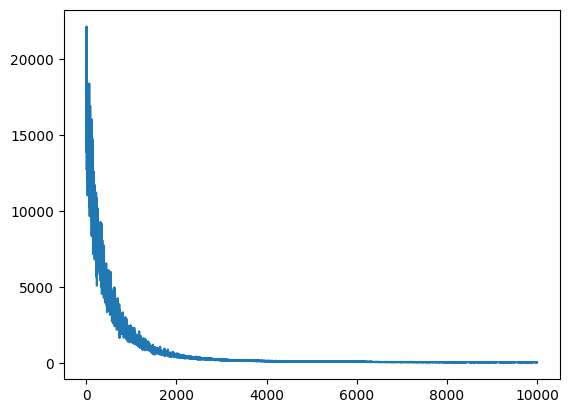

In [ ]:
plt.plot(losses_without_activation)

In [ ]:
toy_model_config_act = ToyConfig()
toy_model_config_act.feature_prob = 1.0
model_act = ToyModelActivation(toy_model_config_act)
importances = torch.tensor(0.7**torch.arange(toy_model_config_act.in_features))
model_act, losses_with_activation = train(model_act, importances, toy_model_config_act)

<ipython-input-131-c8a1c8e48b96>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  importances = torch.tensor(0.9**torch.arange(toy_model_config_act.in_features))


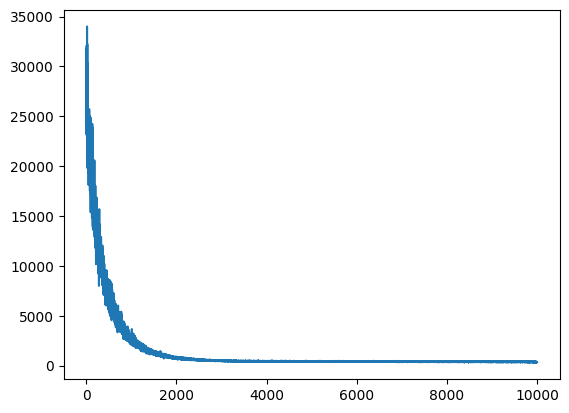

In [ ]:
plt.plot(losses_with_activation)

In [ ]:
model_act.bias

Parameter containing:
tensor([-0.0128, -0.0268, -0.1874, -0.1760, -1.9912, -0.2102, -0.0890, -0.0242,
        -0.0956, -1.0971, -1.4442, -0.0824, -0.0849, -0.6796, -0.2852, -0.0703,
        -0.2565, -1.0134, -0.2370, -0.6180], requires_grad=True)

In [ ]:
def visualize_weights(model, filename="weights9.png"):
    fig, axs = plt.subplots(1, 2, figsize=(7, 4.5))
    colors = [(.4, 0, 1), (1, 1, 1), (1, .4, 0)]
    n_bins = 100
    cm = LinearSegmentedColormap.from_list("", colors, N=n_bins)
    norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

    W = model.weight.data.numpy().T @ model.weight.data.numpy()
    bias = model.bias.data.numpy()[:, None]

    axs[0].imshow(W, cmap=cm, norm=norm)
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    axs[1].imshow(bias, cmap=cm, norm=norm)
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    fig.subplots_adjust(left=0.0, right=1.4)
    fig.tight_layout()
    fig.savefig(filename)

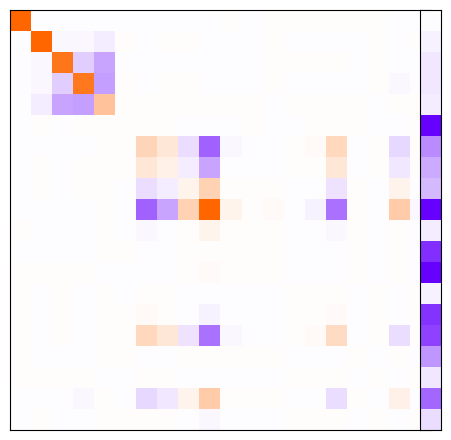

In [ ]:
visualize_weights(model_act, filename="weights_act2.png")

In [ ]:
import numpy as np

def generate_data(T, num_features=10000, sparsity=0.999):
    # Sparse feature vectors with importance ~1/k^2
    X = np.zeros((T, num_features))
    for t in range(T):
        # Sample sparse features
        active_features = np.random.choice(num_features, size=int(num_features * (1 - sparsity)), replace=False)
        X[t, active_features] = np.random.randn(len(active_features)) * (1 / np.sqrt(np.arange(1, len(active_features)+1)))
    # Labels are random projections (simplified)
    W_true = np.random.randn(num_features, 1)
    y = X @ W_true
    return X, y

In [ ]:
import torch
import torch.nn as nn

class ReLUOutputModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=2):
        super().__init__()
        self.W = nn.Linear(input_dim, hidden_dim, bias=False)
        self.b = nn.Parameter(torch.zeros(hidden_dim))
        self.output_layer = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        h = torch.relu(self.W(x) + self.b)
        return self.output_layer(h)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
def train_model(T, hidden_dim=2, weight_decay=0.01, epochs=50000):
    X, y = generate_data(T)
    # print(X.shape, y.shape)
    model = ReLUOutputModel(X.shape[1], hidden_dim).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
    criterion = nn.MSELoss()

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return model, losses

In [ ]:
def compute_dimensionality(model, X):
    W = model.W.weight.detach().cpu().numpy()
    b = model.b.detach().cpu().numpy()

    # Feature dimensionality: ||W_i||^2 / (sum_j ||W_j||^2)
    feature_norms = np.linalg.norm(W, axis=1)**2
    feature_dim = feature_norms / np.sum(feature_norms)

    # Data point dimensionality: ||h(x_t)||^2 / (sum_t ||h(x_t)||^2)
    h = np.maximum(X @ W.T + b, 0)
    data_norms = np.linalg.norm(h, axis=1)**2
    data_dim = data_norms / np.sum(data_norms)

    return feature_dim, data_dim

In [ ]:
import matplotlib.pyplot as plt

def plot_double_descent(dataset_sizes, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(dataset_sizes, test_losses, marker='o', linestyle='-', color='#2ca02c')
    plt.xlabel('Dataset Size (T)', fontsize=12)
    plt.ylabel('Test Loss', fontsize=12)
    plt.title('Double Descent in Toy Model', fontsize=14)
    plt.axvline(x=1000, color='r', linestyle='--', label='Transition Point')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.savefig('double_descent.png', dpi=300)
    plt.show()

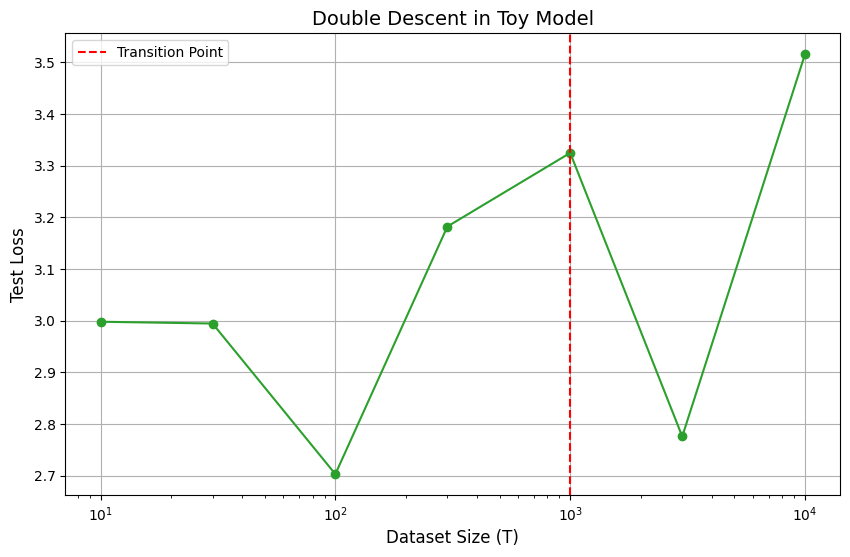

In [ ]:
# Sweep over dataset sizes
dataset_sizes = [10, 30, 100, 300, 1000, 3000, 10000]
test_losses = []

for T in dataset_sizes:
    model, _ = train_model(T)
    X_test, y_test = generate_data(T=1000)  # Generate test data
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    test_loss = nn.MSELoss()(y_pred, torch.tensor(y_test, dtype=torch.float32).to(device))
    test_losses.append(test_loss.item())

# Plot results
plot_double_descent(dataset_sizes, test_losses)

In [ ]:
from sklearn.decomposition import PCA

def plot_feature_geometry(model, X, title=""):
    # Extract weights and biases
    W = model.W.weight.detach().cpu().numpy()
    b = model.b.detach().cpu().numpy()

    # Compute hidden activations for test data
    with torch.no_grad():
        h = torch.relu(model.W(torch.tensor(X, dtype=torch.float32)) + model.b)
        h = h.cpu().numpy()

    # PCA for dimensionality reduction
    pca = PCA(n_components=2)
    W_pca = pca.fit_transform(W.T)  # Features (columns of W)
    h_pca = pca.transform(h)        # Hidden activations

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot feature vectors (W)
    plt.scatter(W_pca[:, 0], W_pca[:, 1], alpha=0.6,
                color='blue', label='Feature Vectors (W)')

    # Plot hidden activations (h)
    plt.scatter(h_pca[:, 0], h_pca[:, 1], alpha=0.4,
                color='red', label='Hidden Activations')

    plt.title(f'Feature Geometry: {title}', fontsize=14)
    plt.xlabel('PCA 1', fontsize=12)
    plt.ylabel('PCA 2', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_dimensionality_curves(dataset_sizes, feature_dims, data_dims):
    plt.figure(figsize=(10, 6))
    plt.plot(dataset_sizes, feature_dims, marker='o',
             label='Feature Dimensionality', color='blue')
    plt.plot(dataset_sizes, data_dims, marker='s',
             label='Data Dimensionality', color='red')
    plt.xlabel('Dataset Size (T)', fontsize=12)
    plt.ylabel('Normalized Dimensionality', fontsize=12)
    plt.title('Dimensionality Allocation Transition', fontsize=14)
    plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

<ipython-input-17-9d58a67e519e>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h = torch.relu(model.W(torch.tensor(X, dtype=torch.float32)) + model.b)


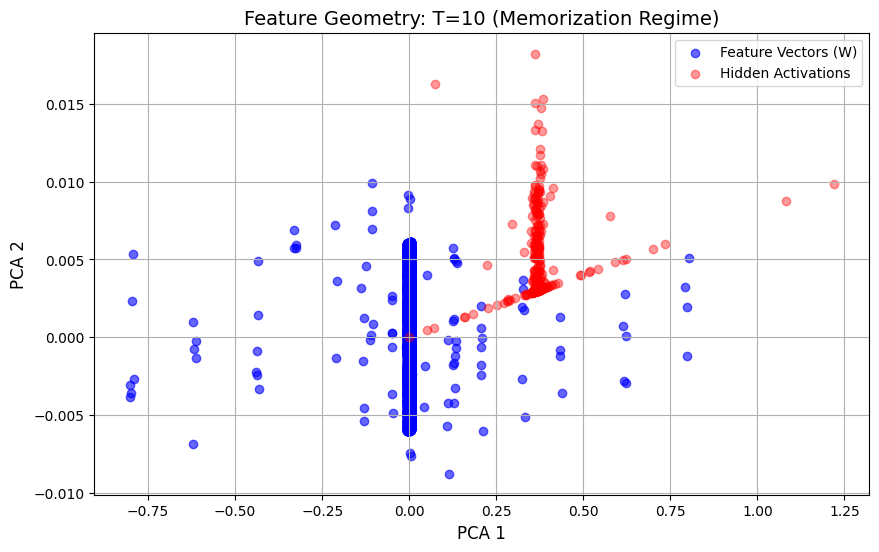

<ipython-input-17-9d58a67e519e>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h = torch.relu(model.W(torch.tensor(X, dtype=torch.float32)) + model.b)


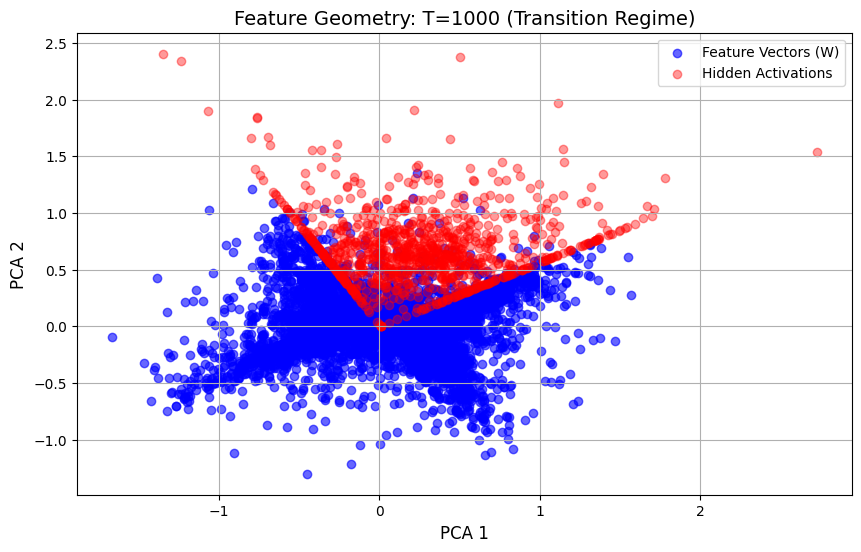

<ipython-input-17-9d58a67e519e>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h = torch.relu(model.W(torch.tensor(X, dtype=torch.float32)) + model.b)


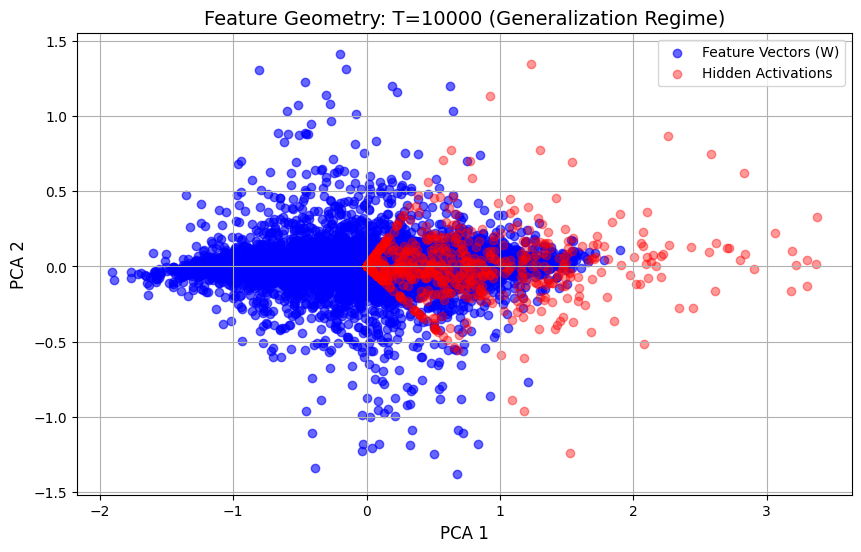

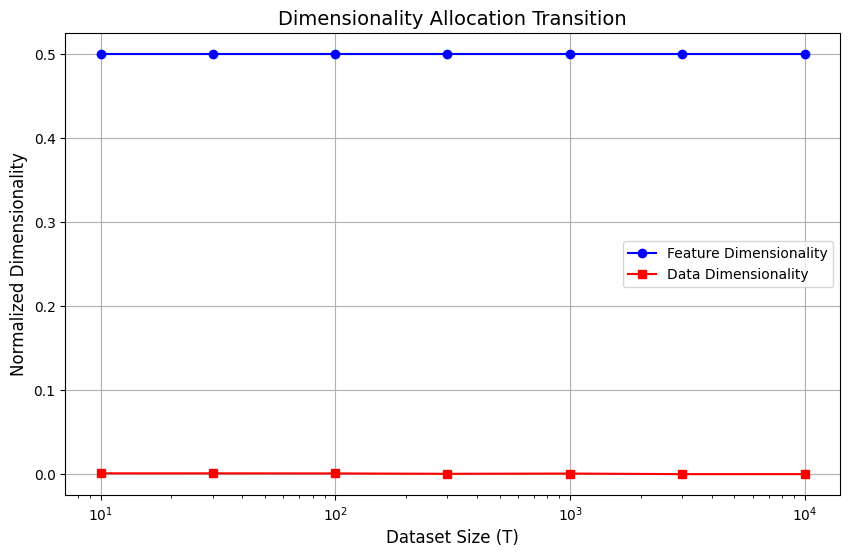

In [ ]:
# Train models and collect geometry data
dataset_sizes = [10, 30, 100, 300, 1000, 3000, 10000]
feature_dimensionalities = []
data_dimensionalities = []

for T in dataset_sizes:
    model, _ = train_model(T, hidden_dim=2)  # Use 2D hidden layer for visualization
    X_test, _ = generate_data(T=1000)

    # Compute dimensionalities
    feature_dim, data_dim = compute_dimensionality(model, X_test)
    feature_dimensionalities.append(np.median(feature_dim))
    data_dimensionalities.append(np.median(data_dim))

    # Plot geometry for key regimes
    if T in [10, 1000, 10000]:
        plot_feature_geometry(model, torch.tensor(X_test, device=device),
                             title=f'T={T} ({["Memorization","Transition","Generalization"][dataset_sizes.index(T)//3]} Regime)')

# Plot dimensionality curves
plot_dimensionality_curves(dataset_sizes, feature_dimensionalities, data_dimensionalities)